In [25]:
# After training the old CNN architecture on the CWTs of the 3 beat segments,
# will now see how it performs on the unseen test data

In [26]:
# import relevant modules
import pickle as pkl
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
from coord import CoordinateChannel2D
print(tf.__version__)

1.15.5


Model: "old_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1Dseries (InputLayer)        [(None, 2800, 2)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2798, 32)          224       
_________________________________________________________________
batch_normalization (BatchNo (None, 2798, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1399, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1397, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 698, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 694, 64)           10

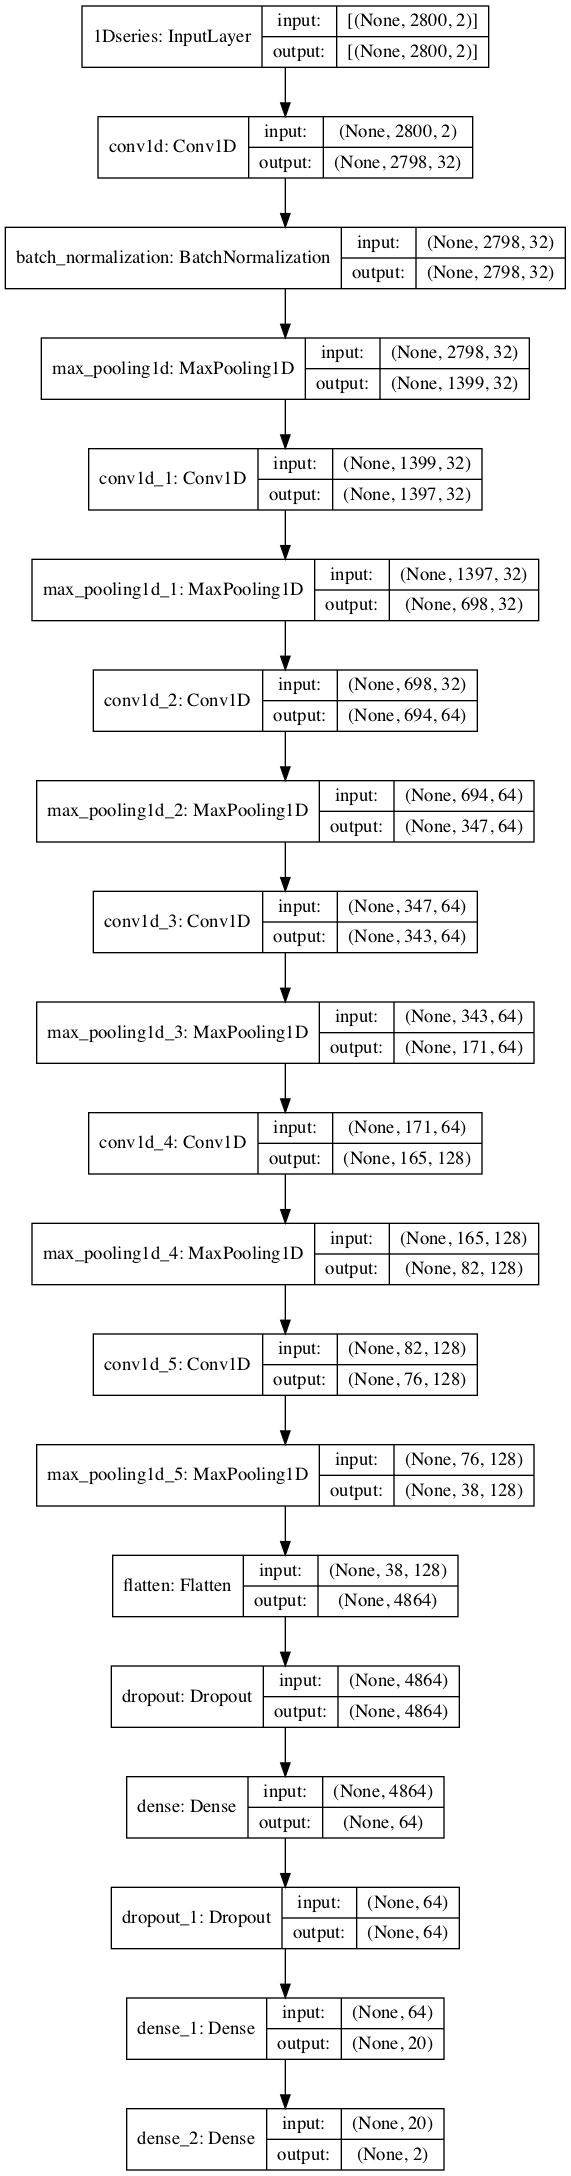

In [28]:
location = '1D final binary/no shuffle'
foldnum = 5
model = load_model('{}/final_model_save.h5'.format(location))
with open('{}/final_history.pkl'.format(location), 'rb') as f:
    model_history = pkl.load(f)
print(model.summary())
print(model_history.keys())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<function matplotlib.pyplot.show(close=None, block=None)>

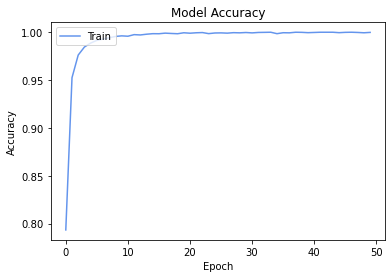

In [29]:
plt.figure()
plt.plot(model_history['categorical_accuracy'], 'cornflowerblue')
#plt.plot(model_history['val_categorical_accuracy'], 'lightcoral')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show

[1. 0.]


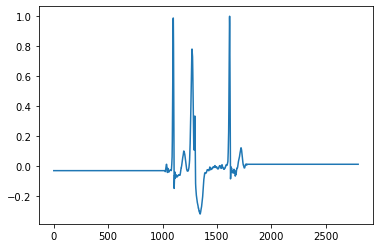

In [30]:
import pickle as pkl
test_images = []

# cycle through and add all test images to array
for i in range(4000):
     with open('3 Beat binary Scaled 1D Test/sample_{}.npy'.format(i), 'rb') as file:
        image = np.load(file)
        test_images.append(image)
# load in labels
plt.plot(test_images[2005][:,0])
test_images = np.array(test_images)
with open('1DCNN_binary_3_Beat_Test_Labels_OHE.pkl', 'rb') as f:
    test_labels_OHE = pkl.load(f)
test_labels_OHE = np.array(test_labels_OHE)
print(test_labels_OHE[990])

In [31]:
predictions = model.predict(test_images)
print(len(predictions))
print(predictions[180])
# see how model performs on the unseen data

4000
[1.000000e+00 6.842417e-16]


In [32]:
print(predictions)

[[1.0000000e+00 1.2227755e-13]
 [1.0000000e+00 1.4317116e-09]
 [1.0000000e+00 4.2930476e-15]
 ...
 [1.0415204e-06 9.9999893e-01]
 [5.7985239e-06 9.9999416e-01]
 [1.7473940e-05 9.9998248e-01]]


In [33]:
print(test_labels_OHE)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [34]:
# round all predictions to nearest integer
maxes = np.argmax(predictions, axis = 1)
print(maxes)
for c,i in enumerate(maxes):
    predictions[c] = np.zeros((2,))
    predictions[c][i] = 1
print(predictions)
print(len(predictions))

[0 0 0 ... 1 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
4000


In [35]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cat_true = []
for i in test_labels_OHE:
    cat_true.append(np.argmax(i))
cat_predictions = []
for i in predictions:
    cat_predictions.append(np.argmax(i))
conf_mat = confusion_matrix(cat_true, cat_predictions)
print(conf_mat)

[[1996    4]
 [   2 1998]]


In [36]:
# Work out accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(cat_true, cat_predictions)
print(acc)
file = open('test_scores/test_acc_score_2D_final.txt', 'w')
file.write('accuracy = {}'.format(acc))
file.close()

0.9985


In [ ]:
# define function to plot confusion matrices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes = ['N','AFIB'])
plt.savefig('Final 1D Binary Conf Matrix no norm.pdf')          
plt.figure()
plot_confusion_matrix(conf_mat, classes = ['N','AFIB'], normalize = True)
plt.savefig('Final 1D Binary Conf Matrix norm.pdf')  